In [16]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [68]:
import h5py
import math
import re
import lm.input.Input_pb2 as inp
import lm.io.ConcentrationsTimeSeries_pb2 as cts
import lm.types.BoundaryConditions_pb2 as bc
from robertslab import ndarray
from robertslab.sfile import SFile
testNames=[
           "one_d_diffusion_reflecting_x",
           "one_d_diffusion_reflecting_y",
           "one_d_diffusion_reflecting_z",
           "one_d_diffusion_absorbing_x",
           "one_d_diffusion_absorbing_y",
           "one_d_diffusion_absorbing_z",
           "one_d_diffusion_linear_x",
           "one_d_diffusion_linear_y",
           "one_d_diffusion_linear_z",
           "one_d_diffusion_large_linear",
           "two_d_diffusion",
           "three_d_diffusion",
]
test_names_bash_list=" ".join(testNames)
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [69]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [70]:
%%bash
rm -rf tmp && mkdir tmp

### Analytical solutions for diffusion with flux at +/- infinity bounded to 0.
#### 1D
The concentration as a function of $x$ and $t$ is given by $c(x,t) = \frac{N}{\sqrt{4{\pi}Dt}} exp(-\frac{x^2}{4Dt})$, where $N=\int_{-\infty}^{\infty}c(x,t)dx$. See https://home.icts.res.in/~abhi/notes/lect3.pdf

#### 2D
The concentration as a function of $x$, $y$, and $t$ is given by $c(x,y,t) = \frac{N}{4{\pi}Dt} exp(-\frac{x^2+y^2}{4Dt})$, where $N=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}c(x,y,t)\,dx\,dy$. See http://www.rpgroup.caltech.edu/courses/aph162/2006/Protocols/diffusion.pdf

#### 3D
The concentration as a fucntion of $x$, $y$, $z$, and $t$ is given by $c(x,y,z,t) = \frac{N}{(4{\pi}Dt)^{3/2}} exp(-\frac{x^2+y^2+z^2}{4Dt})$, where $N=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}c(x,y,z,t)\,dx\,dy\,dz$.

In [77]:
def diffusionInfiniteDomain1D(x, t, C0, l, D):
    N=C0*l
    return (N/sqrt(4*pi*D*t))*exp(-((x**2)/(4*D*t)))

def diffusionInfiniteDomain2D(x, y, t, C0, l, D):
    N=C0*l*l
    C=np.zeros((x.shape[0],y.shape[0]))
    for i in range(0,y.shape[0]):
        C[:,i]=(N/(4*pi*D*t))*exp(-((x**2+y[i]**2)/(4*D*t)))
    return C

def diffusionInfiniteDomain3D(x, y, z, t, C0, l, D):
    N=C0*l*l*l
    C=np.zeros((x.shape[0],y.shape[0],z.shape[0]))
    for j in range(0,z.shape[0]):
        for i in range(0,y.shape[0]):
            C[:,i,j]=(N/(4*pi*D*t)**(3.0/2.0))*exp(-((x**2+y[i]**2+z[j]**2)/(4*D*t)))
    return C

### Create the test input files.

In [78]:
def create_one_d_diffusion(testInputFilename):
    m = re.match(".*/one_d_diffusion_(.+)_(.+)\.", testInputFilename)
    if m is None: return
    
    boundaryString = m.group(1)
    axis = m.group(2)
    if boundaryString == "reflecting":
        boundary = bc.BoundaryConditions().REFLECTING
    elif boundaryString == "absorbing":
        boundary = bc.BoundaryConditions().ABSORBING
    elif boundaryString == "linear":
        boundary = bc.BoundaryConditions().LINEAR_GRADIENT        

    input=inp.Input()
    input.microenv_model.grid_spacing = 4.0e-6
    input.microenv_model.species_index.append(0)
    input.microenv_model.diffusion_coefficients.append(1000e-12)
    input.microenv_model.boundaries.axis_specific_boundaries = True
    input.microenv_model.initial_time = 0.0;
    input.microenv_model.synchronization_timestep = 0.01;
    input.microenv_model.boundaries.x_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.x_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.z_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.z_minus = bc.BoundaryConditions().REFLECTING
    if axis == "x":
        gridShape=(101,1,1)
        input.microenv_model.boundaries.x_plus = boundary
        input.microenv_model.boundaries.x_minus = boundary
    elif axis == "y":
        gridShape=(1,101,1)
        input.microenv_model.boundaries.y_plus = boundary
        input.microenv_model.boundaries.y_minus = boundary
    elif axis == "z":
        gridShape=(1,1,101)
        input.microenv_model.boundaries.z_plus = boundary
        input.microenv_model.boundaries.z_minus = boundary

    # Set the initial grid.
    input.microenv_model.grid_shape.extend(gridShape)
    grid = np.zeros(gridShape)
    grid[grid.shape[0]//2,grid.shape[1]//2,grid.shape[2]//2] = 1.0e-6
    ndarray.serializeIntoPbufMessage(input.microenv_model.initial_concentrations.add(), grid)

    # Write the input to the file.
    file=SFile.fromFilename("%s.sfile"%(testInputFilename), "w")
    file.writeRecord("input", "protobuf:lm.input.Input", stringData=input.SerializeToString())
    file.close()        

In [79]:
def create_one_d_diffusion_large_linear(testInputFilename):
    gridShape=(1,1,10001)
    input=inp.Input()
    input.microenv_model.initial_time = 0.0;
    input.microenv_model.synchronization_timestep = 0.01;
    input.microenv_model.grid_shape.extend(gridShape)
    input.microenv_model.grid_spacing = 4.0e-6
    input.microenv_model.species_index.append(0)
    input.microenv_model.diffusion_coefficients.append(1000e-12)
    input.microenv_model.boundaries.axis_specific_boundaries = True
    input.microenv_model.boundaries.x_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.x_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.z_plus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.z_minus = bc.BoundaryConditions().LINEAR_GRADIENT
    grid = np.zeros(gridShape)
    grid[grid.shape[0]//2,grid.shape[1]//2,grid.shape[2]//2] = 1.0e-6
    ndarray.serializeIntoPbufMessage(input.microenv_model.initial_concentrations.add(), grid)

    # Write the input to the file.
    file=SFile.fromFilename("%s.sfile"%(testInputFilename), "w")
    file.writeRecord("input", "protobuf:lm.input.Input", stringData=input.SerializeToString())
    file.close()        

In [80]:
def create_two_d_diffusion(testInputFilename):
    gridShape=(1,201,201)
    input=inp.Input()
    input.microenv_model.initial_time = 0.0;
    input.microenv_model.synchronization_timestep = 0.01;
    input.microenv_model.grid_shape.extend(gridShape)
    input.microenv_model.grid_spacing = 4.0e-6
    input.microenv_model.species_index.append(0)
    input.microenv_model.diffusion_coefficients.append(1000e-12)
    input.microenv_model.boundaries.axis_specific_boundaries = True
    input.microenv_model.boundaries.x_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.x_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_plus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.y_minus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.z_plus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.z_minus = bc.BoundaryConditions().LINEAR_GRADIENT
    grid = np.zeros(gridShape)
    grid[grid.shape[0]//2,grid.shape[1]//2,grid.shape[2]//2] = 1.0e-6
    ndarray.serializeIntoPbufMessage(input.microenv_model.initial_concentrations.add(), grid)

    # Write the input to the file.
    file=SFile.fromFilename("%s.sfile"%(testInputFilename), "w")
    file.writeRecord("input", "protobuf:lm.input.Input", stringData=input.SerializeToString())
    file.close()

In [81]:
def create_three_d_diffusion(testInputFilename):
    gridShape=(201,201,201)
    input=inp.Input()
    input.microenv_model.initial_time = 0.0;
    input.microenv_model.synchronization_timestep = 0.01;
    input.microenv_model.grid_shape.extend(gridShape)
    input.microenv_model.grid_spacing = 4.0e-6
    input.microenv_model.species_index.append(0)
    input.microenv_model.diffusion_coefficients.append(1000e-12)
    input.microenv_model.boundaries.axis_specific_boundaries = True
    input.microenv_model.boundaries.x_plus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.x_minus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.y_plus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.y_minus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.z_plus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.z_minus = bc.BoundaryConditions().LINEAR_GRADIENT
    grid = np.zeros(gridShape)
    grid[grid.shape[0]//2,grid.shape[1]//2,grid.shape[2]//2] = 1.0e-6
    ndarray.serializeIntoPbufMessage(input.microenv_model.initial_concentrations.add(), grid)

    # Write the input to the file.
    file=SFile.fromFilename("%s.sfile"%(testInputFilename), "w")
    file.writeRecord("input", "protobuf:lm.input.Input", stringData=input.SerializeToString())
    file.close()

In [82]:
createMethods = {"one_d_diffusion_reflecting_x": create_one_d_diffusion,
               "one_d_diffusion_reflecting_y": create_one_d_diffusion,
               "one_d_diffusion_reflecting_z": create_one_d_diffusion,
               "one_d_diffusion_absorbing_x": create_one_d_diffusion,
               "one_d_diffusion_absorbing_y": create_one_d_diffusion,
               "one_d_diffusion_absorbing_z": create_one_d_diffusion,
               "one_d_diffusion_linear_x": create_one_d_diffusion,
               "one_d_diffusion_linear_y": create_one_d_diffusion,
               "one_d_diffusion_linear_z": create_one_d_diffusion,
               "one_d_diffusion_large_linear": create_one_d_diffusion_large_linear,
               "two_d_diffusion": create_two_d_diffusion,
               "three_d_diffusion": create_three_d_diffusion}
for testName in testNames:
    testInputFilename="tmp/%s.input"%(testName)
    createMethods[testName](testInputFilename)
print "Finished."
pass

Finished.


In [83]:
%%bash -s "$test_names_bash_list"
sbmlFilename="microenv_diffusion.sbml"
for testName in $1; do
    lmInputFilename=tmp/${testName}.input.lm
    
    rm -f ${lmInputFilename} && lm_sbml_import ${lmInputFilename} ${sbmlFilename} > ${lmInputFilename}.import.log
    if [[ ${testName} == one_d* ]]; then
        lm_setp ${lmInputFilename} writeInterval=1e-1 maxTime=1e2 > /dev/null
    elif [[ ${testName} == two_d* ]]; then
        lm_setp ${lmInputFilename} writeInterval=1e-1 maxTime=1e1 > /dev/null
    elif [[ ${testName} == three_d* ]]; then
        lm_setp ${lmInputFilename} writeInterval=1e-1 maxTime=1e0 > /dev/null
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
done;
echo "Finished."

Finished.


### Execute the simulations.

In [84]:
%%bash -s "$test_names_bash_list"
sbmlFilename="microenv_diffusion.sbml"
for testName in $1; do
    lmInputFilename=tmp/${testName}.input.lm
    sfileInputFilename=tmp/${testName}.input.sfile
    outputFilename=tmp/${testName}.sfile
    
    if [[ ${testName} == *_avx ]]; then
        lmes -r 1-1 -me -f ${lmInputFilename},${sfileInputFilename} -ff sfile -fo ${outputFilename} -sl lm::avx::GillespieDSolverAVX > ${outputFilename}.simulate.log
    else
        lmes -r 1-1 -me -f ${lmInputFilename},${sfileInputFilename} -ff sfile -fo ${outputFilename} -sl lm::cme::GillespieDSolver > ${outputFilename}.simulate.log
    fi
done;
echo "Finished."

Finished.


### Define the tests.

In [85]:
def test_one_d_diffusion(testOutputFilename):
    m = re.match(".*/one_d_diffusion_(.+)_(.+)\.", testOutputFilename)
    if m is None: raise Exception("invalid test name"%(testOutputFilename))
    boundaryString = m.group(1)
    if boundaryString == "reflecting":
        boundary = bc.BoundaryConditions().REFLECTING
    elif boundaryString == "absorbing":
        boundary = bc.BoundaryConditions().ABSORBING
    elif boundaryString == "linear":
        boundary = bc.BoundaryConditions().LINEAR_GRADIENT        
    axis = m.group(2)
    
    # Get the grid size and count the entries.
    numberRecords=0
    gridShape=None
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.name == "/Replicates/1/Simulations/0/ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            numberRecords += obj.times.shape[0]
            if gridShape is None:
                gridShape = tuple(obj.concentrations[0].shape)
        else:
            file.skipData(record.dataSize)
    file.close();
    if numberRecords != 1001: raise Exception("incorrect number of records",numberRecords)
    if axis == "x" and gridShape != (101,1,1): raise Exception("incorrect grid shape",gridShape)
    if axis == "y" and gridShape != (1,101,1): raise Exception("incorrect grid shape",gridShape)
    if axis == "z" and gridShape != (1,1,101): raise Exception("incorrect grid shape",gridShape)

    # Load the records for this replicate.
    if axis == "x": dim=0
    if axis == "y": dim=1
    if axis == "z": dim=2
    times=np.zeros((numberRecords,), dtype=float)
    grids=np.zeros((numberRecords,gridShape[dim]), dtype=float)
    index=0
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.name == "/Replicates/1/Simulations/0/ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            recordTimes = ndarray.deserializePbufMessage(obj.times)
            for j in range(0,recordTimes.shape[0]):
                times[index] = recordTimes[j]
                grids[index,:] = ndarray.deserializePbufMessage(obj.concentrations[j]).flatten()
                index += 1
        else:
            file.skipData(record.dataSize)
    file.close();
    if times.shape != (1001,): raise Exception("incorrect number of times",times.shape)
    if grids.shape != (1001,101): raise Exception("incorrect number of grids",grids.shape)
    value = np.max(grids,0)[50]
    if not isclose(value,1e-6,1e-3): raise Exception("incorrect maximum concentration",value)
        
    # Calculate the theoretical prediction.
    mass=np.sum(grids, (1,))
    ti=100
    t=times[ti]
    C0=1e-6
    D=1000e-12
    l=4e-6
    x=(np.arange(0,grids.shape[1])-50)*l
    cTheory=np.zeros((x.shape[0],))
    if boundary == bc.BoundaryConditions().REFLECTING:
        cTheory=diffusionInfiniteDomain1D(x,t,C0,l,D)+diffusionInfiniteDomain1D(2*202e-6-x,t,C0,l,D)+diffusionInfiniteDomain1D(2*-202e-6-x,t,C0,l,D)
    elif boundary == bc.BoundaryConditions().ABSORBING:
        cTheory=diffusionInfiniteDomain1D(x,t,C0,l,D)-diffusionInfiniteDomain1D(2*204e-6-x,t,C0,l,D)-diffusionInfiniteDomain1D(2*-204e-6-x,t,C0,l,D)
    elif boundary == bc.BoundaryConditions().LINEAR_GRADIENT:
        cTheory=diffusionInfiniteDomain1D(x,t,C0,l,D)
    
    # Plot the output.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3*2)})
    subplot(2,2,1)
    imshow(log10(grids[:,:]), interpolation='none', aspect=0.03, origin='upper', vmin=-12, vmax=-6)
    cb=colorbar(label="c"); cb.ax.set_aspect(5)
    xlabel("x"); ylabel("Timestep"); title(r"Axis=%s, Boundary=%s"%(axis,bc.BoundaryConditions().BoundaryConditionsType.Name(boundary)))
    subplot(2,2,2)
    plot(times, mass, **plotStyles)
    xlabel("Time (s)"); ylabel("Total Mass")
    subplot(2,2,3)
    plot(x,grids[ti,:], **plotStyles)
    plot(x,cTheory, 'r', **plotStyles)
    xlabel("x"); ylabel("c"); yscale("log"); ylim([1e-12,1e-6]); title("Time=%0.2e"%(t))
    subplot(2,2,4)
    plot(x,abs(grids[ti,:]-cTheory)/cTheory, **plotStyles)
    xlabel("x"); ylabel('Relative Error'); yscale("log"); ylim([1e-6,1e-0]); title("Time=%0.2e"%(t))
        
    # Check the output.
    if boundary == bc.BoundaryConditions().REFLECTING:
        value = np.min(mass)
        if not isclose(value,1e-6,1e-6): raise Exception("incorrect value for minimum mass",value)
        value = np.max(mass)
        if not isclose(value,1e-6,1e-6): raise Exception("incorrect value for maximum mass",value)
        value = np.max(abs(grids[ti,:]-cTheory)/cTheory)
        if value > 1e-4: raise Exception("maximum error too large",value)
    elif boundary == bc.BoundaryConditions().ABSORBING:
        value = np.max(abs(grids[ti,:]-cTheory)/cTheory)
        if value > 3e-3: raise Exception("maximum error too large",value)
    elif boundary == bc.BoundaryConditions().LINEAR_GRADIENT:
        value = np.max(abs(grids[ti,25:-25]-cTheory[25:-25])/cTheory[25:-25])
        if value > 2e-1: raise Exception("maximum error too large",value)

In [90]:
def test_one_d_diffusion_large_linear(testOutputFilename):
    # Get the grid size and count the entries.
    numberRecords=0
    gridShape=None
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.name == "/Replicates/1/Simulations/0/ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            numberRecords += obj.times.shape[0]
            if gridShape is None:
                gridShape = tuple(obj.concentrations[0].shape)
        else:
            file.skipData(record.dataSize)
    file.close();
    if numberRecords != 1001: raise Exception("incorrect number of records",numberRecords)
    if gridShape != (1,1,10001): raise Exception("incorrect grid shape",gridShape)

    # Load the records for this replicate.
    times=np.zeros((numberRecords,), dtype=float)
    grids=np.zeros((numberRecords,gridShape[2]), dtype=float)
    index=0
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.name == "/Replicates/1/Simulations/0/ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            recordTimes = ndarray.deserializePbufMessage(obj.times)
            for j in range(0,recordTimes.shape[0]):
                times[index] = recordTimes[j]
                grids[index,:] = ndarray.deserializePbufMessage(obj.concentrations[j]).flatten()
                index += 1
        else:
            file.skipData(record.dataSize)
    file.close();
    if times.shape != (1001,): raise Exception("incorrect number of times",times.shape)
    if grids.shape != (1001,10001): raise Exception("incorrect number of grids",grids.shape)
    value = np.max(grids,0)[5000]
    if not isclose(value,1e-6,1e-3): raise Exception("incorrect maximum concentration",value)
        
        
    # Calculate the theoretical prediction.
    C0=1e-6
    D=1000e-12
    l=4e-6
    x=(np.arange(0,grids.shape[1])-5000)*l
    comparisonIndices=np.linspace(1,times.shape[0]-1,5, dtype=int)
    cTheory=np.zeros((comparisonIndices.shape[0],grids.shape[1]))
    for i,index in enumerate(comparisonIndices):
        t=times[index]
        cTheory[i,:]=diffusionInfiniteDomain1D(x,t,C0,l,D)

    # Plot the output.
    rows=1+comparisonIndices.shape[0]+1
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3*rows)})
    subplot(rows,2,1)
    imshow(log10(grids[:,:]), interpolation='none', aspect=4.2, origin='upper', vmin=-12, vmax=-8)
    cb=colorbar(label="c"); cb.ax.set_aspect(5)
    xlabel("x"); ylabel("Timestep");
    subplot(rows,2,2)
    mass=np.sum(grids, (1,))
    plot(times, mass, **plotStyles)
    xlabel("Time (s)"); ylabel("Total Mass")
    for i,index in enumerate(comparisonIndices):
        subplot(rows,2,(i+1)*2+1)
        t=times[index]
        xlimit=4*sqrt(2*D*t)/l
        xlimit=(int(ceil(grids.shape[1]/2-xlimit)),int(ceil(grids.shape[1]/2+xlimit)))
        plot(x[xlimit[0]:xlimit[1]], grids[index,xlimit[0]:xlimit[1]], **plotStyles)
        plot(x[xlimit[0]:xlimit[1]], cTheory[i,xlimit[0]:xlimit[1]], 'r', **plotStyles)
        xlim([x[xlimit[0]],x[xlimit[1]]]); xlabel(r"x"); yscale("log"); ylabel("c"); title("t=%0.3f s"%(t))
        subplot(rows,2,(i+1)*2+2)
        plot(x[xlimit[0]:xlimit[1]], abs(cTheory[i,xlimit[0]:xlimit[1]]-grids[index,xlimit[0]:xlimit[1]])/cTheory[i,xlimit[0]:xlimit[1]], **plotStyles)
        xlim([x[xlimit[0]],x[xlimit[1]]]); xlabel(r"x"); yscale("log"); ylabel("Relative Error");
    subplot(rows,2,rows*2-1)
    varSim=np.zeros(times.shape)
    for i in range(0,len(varSim)):
        c=grids[i,:]
        N=np.sum(c)
        varSim[i]=np.sum((x**2)*c/N)
    varTheory=2*D*times
    plot(times[1:],varSim[1:], **plotStyles);
    plot(times[1:],varTheory[1:], 'r', **plotStyles);
    xlabel("t (s)"); yscale("log"); ylabel("var(c)")
    subplot(rows,2,rows*2)
    varErr=abs(varSim-varTheory)/varTheory
    plot(times,varErr)
    xlabel("t (s)");  ylabel("Relative Error");

    # Check the output.
    acceptableErrors=[4e-1,5e-3,2e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3]
    for i,index in enumerate(comparisonIndices):
        t=times[index]
        xlimit=4*sqrt(2*D*t)/l
        xlimit=(int(ceil(grids.shape[1]/2-xlimit)),int(ceil(grids.shape[1]/2+xlimit)))
        errors=abs(cTheory[i,xlimit[0]:xlimit[1]]-grids[index,xlimit[0]:xlimit[1]])/cTheory[i,xlimit[0]:xlimit[1]]
        value = np.max(errors)
        if value > acceptableErrors[i]: raise Exception("maximum error too large",i,value)
        value = np.max(varErr)
        if value > 1e-12: raise Exception("maximum error in variance too large",i,value)

In [87]:
def test_two_d_diffusion(testOutputFilename):
    # Get the grid size and count the entries.
    numberRecords=0
    gridShape=None
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.name == "/Replicates/1/Simulations/0/ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            numberRecords += obj.times.shape[0]
            if gridShape is None:
                gridShape = tuple(obj.concentrations[0].shape)
        else:
            file.skipData(record.dataSize)
    file.close();
    if numberRecords != 101: raise Exception("incorrect number of records",numberRecords)
    if gridShape != (1,201,201): raise Exception("incorrect grid shape",gridShape)

    # Load the records for this replicate.
    times=np.zeros((numberRecords,), dtype=float)
    grids=np.zeros((numberRecords,gridShape[1],gridShape[2]), dtype=float)
    index=0
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.name == "/Replicates/1/Simulations/0/ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            recordTimes = ndarray.deserializePbufMessage(obj.times)
            for j in range(0,recordTimes.shape[0]):
                times[index] = recordTimes[j]
                grids[index,:,:] = ndarray.deserializePbufMessage(obj.concentrations[j])
                index += 1
        else:
            file.skipData(record.dataSize)
    file.close();
    if times.shape != (101,): raise Exception("incorrect number of times",times.shape)
    if grids.shape != (101,201,201): raise Exception("incorrect number of grids",grids.shape)
    value = np.max(grids,0)[100,100]
    if not isclose(value,1e-6,1e-3): raise Exception("incorrect maximum concentration",value)
        
    # Calculate the theoretical prediction.
    C0=1e-6
    D=1000e-12
    l=4e-6
    x=(np.arange(0,grids.shape[1])-100)*l
    y=(np.arange(0,grids.shape[2])-100)*l
    cTheory=np.zeros(grids.shape)
    for i in range(0,grids.shape[0]):
        cTheory[i,:,:]=diffusionInfiniteDomain2D(x,y,times[i],C0,l,D)    
        cErr=np.abs(cTheory-grids)/cTheory

    # Calculate the simualted and theoretical variance.
    varSim=np.zeros(times.shape)
    for i in range(0,len(varSim)):
        c=grids[i,:,:]
        N=np.sum(c)
        varSim[i]=np.sum((x**2+y**2)*c/N)
    varTheory=4*D*times
    varErr=abs(varSim-varTheory)/varTheory
        
    # Plot the output.
    comparisonIndices=np.linspace(1,times.shape[0]-1,5, dtype=int)
    rows=comparisonIndices.shape[0]+1
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3*rows)})
    for i,index in enumerate(comparisonIndices):
        subplot(rows,3,(i*3)+1)
        imshow(log10(grids[index,:,:]), interpolation='none', aspect=1, origin='lower', vmin=-12, vmax=-8)
        cb=colorbar(label="c"); cb.ax.set_aspect(5)
        xlabel(r"x"); ylabel("y"); title("Sim t=%0.3f s"%times[index])
        subplot(rows,3,(i*3)+2)
        imshow(log10(cTheory[index,:,:]), interpolation='none', aspect=1, origin='lower', vmin=-12, vmax=-8)
        cb=colorbar(label="c"); cb.ax.set_aspect(5)
        xlabel(r"x"); ylabel("y"); title("Theory")
        subplot(rows,3,(i*3)+3)
        imshow(log10(cErr[index,:,:]), interpolation='none', aspect=1, origin='lower', vmin=-3, vmax=0)
        cb=colorbar(label="$log_{10}(|error|)$"); cb.ax.set_aspect(5)
        xlabel(r"x"); ylabel("y");

    subplot(rows,3,rows*3-2)
    plot(times[1:],varSim[1:], **plotStyles);
    xlabel("t (s)"); yscale("log"); ylabel("var(c)"); title("Sim")
    subplot(rows,3,rows*3-1)
    plot(times[1:],varTheory[1:], **plotStyles);
    xlabel("t (s)"); yscale("log"); ylabel("var(c)"); title("Theory")
    subplot(rows,3,rows*3)
    plot(times,varErr)
    xlabel("t (s)"); yscale('log'); ylabel("Relative Error");
            
    # Check the output.
    acceptableErrors=[7e8,4e-3,1e-3,1e-3,1e-3]
    for i,index in enumerate(comparisonIndices):
        value = np.nanmax(cErr[index,50:150,50:150])
        if value > acceptableErrors[i]: raise Exception("maximum error too large",i,value)
    value = np.nanmax(varErr)
    if value > 1e-1: raise Exception("maximum error in variance too large",i,value)            

In [88]:
def test_three_d_diffusion(testOutputFilename):
    # Get the grid size and count the entries.
    numberRecords=0
    gridShape=None
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.name == "/Replicates/1/Simulations/0/ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            numberRecords += obj.times.shape[0]
            if gridShape is None:
                gridShape = tuple(obj.concentrations[0].shape)
        else:
            file.skipData(record.dataSize)
    file.close();
    if numberRecords != 11: raise Exception("incorrect number of records",numberRecords)
    if gridShape != (201,201,201): raise Exception("incorrect grid shape",gridShape)

    # Load the records for this replicate.
    times=np.zeros((numberRecords,), dtype=float)
    grids=np.zeros((numberRecords,gridShape[0],gridShape[1],gridShape[2]), dtype=float)
    index=0
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.name == "/Replicates/1/Simulations/0/ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            recordTimes = ndarray.deserializePbufMessage(obj.times)
            for j in range(0,recordTimes.shape[0]):
                times[index] = recordTimes[j]
                grids[index,:,:] = ndarray.deserializePbufMessage(obj.concentrations[j])
                index += 1
        else:
            file.skipData(record.dataSize)
    file.close();
    if times.shape != (11,): raise Exception("incorrect number of times",times.shape)
    if grids.shape != (11,201,201,201): raise Exception("incorrect number of grids",grids.shape)
    value = np.max(grids,0)[100,100,100]
    if not isclose(value,1e-6,1e-3): raise Exception("incorrect maximum concentration",value)
        
    # Calculate the theoretical prediction.
    C0=1e-6
    D=1000e-12
    l=4e-6
    x=(np.arange(0,grids.shape[1])-100)*l
    y=(np.arange(0,grids.shape[2])-100)*l
    z=(np.arange(0,grids.shape[3])-100)*l
    cTheory=np.zeros(grids.shape)
    for i in range(0,grids.shape[0]):
        cTheory[i,:,:,:]=diffusionInfiniteDomain3D(x,y,z,times[i],C0,l,D)    
        cErr=np.abs(cTheory-grids)/cTheory

    # Calculate the simulated and theoretical variance.
    varSim=np.zeros(times.shape)
    for i in range(0,len(varSim)):
        c=grids[i,:,:]
        N=np.sum(c)
        varSim[i]=np.sum((x**2+y**2+z**2)*c/N)
    varTheory=6*D*times
    varErr=abs(varSim-varTheory)/varTheory
        
    # Plot the output.
    comparisonIndices=np.linspace(1,times.shape[0]-1,5, dtype=int)
    zIndices=np.array([75,87,100,113,125])
    rows=comparisonIndices.shape[0]*3*zIndices.shape[0]
    cols=zIndices.shape[0]
    matplotlib.rcParams.update({'font.size': 10, "figure.figsize": (20,3*rows)})
    for i,index in enumerate(comparisonIndices):
        for j,zindex in enumerate(zIndices):
            subplot(rows,cols,(i*3*cols)+j+1)
            imshow(log10(grids[index,:,:,zindex]), interpolation='none', aspect=1, origin='lower', vmin=-12, vmax=-8)
            cb=colorbar(label="c"); cb.ax.set_aspect(5)
            xlabel(r"x"); ylabel("y"); title("Sim z=%d,t=%0.3f"%(zindex,times[index]))
            
            subplot(rows,cols,(i*3*cols)+cols+j+1)
            imshow(log10(cTheory[index,:,:,zindex]), interpolation='none', aspect=1, origin='lower', vmin=-12, vmax=-8)
            cb=colorbar(label="c"); cb.ax.set_aspect(5)
            xlabel(r"x"); ylabel("y"); title("Theory z=%d,t=%0.3f"%(zindex,times[index]))
            
            subplot(rows,cols,(i*3*cols)+2*cols+j+1)
            imshow(log10(cErr[index,:,:,zindex]), interpolation='none', aspect=1, origin='lower', vmin=-3, vmax=-0)
            cb=colorbar(label="$log_{10}(|error|)$"); cb.ax.set_aspect(5)
            xlabel(r"x"); ylabel("y"); title("Error z=%d,t=%0.3f"%(zindex,times[index]))
        
    #matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    #subplot(1,3,1)
    #plot(times[1:],varSim[1:], **plotStyles);
    #xlabel("t (s)"); yscale("log"); ylabel("var(c)"); title("Sim")
    #subplot(1,3,2)
    #plot(times[1:],varTheory[1:], **plotStyles);
    #xlabel("t (s)"); yscale("log"); ylabel("var(c)"); title("Theory")
    #subplot(1,3,3)
    #plot(times,varErr)
    #xlabel("t (s)"); yscale('log'); ylabel("Relative Error");
            
    # Check the output.
    acceptableErrors=[2e1,5e-1,2e-1,5e-2,2e-2]
    for i,index in enumerate(comparisonIndices):
        value = np.nanmax(cErr[index,75:125,75:125,75:125])
        if value > acceptableErrors[i]: raise Exception("maximum error too large",i,value)
    value = np.nanmax(varErr)
    if value > 1e-6: raise Exception("maximum error in variance too large",i,value)            

### Run the tests.

[one_d_diffusion_reflecting_x]                               : passed.


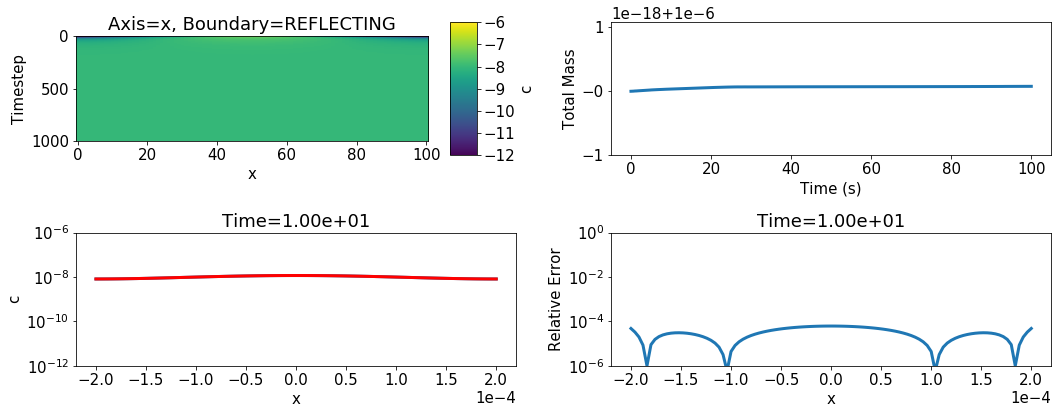

[one_d_diffusion_reflecting_y]                               : passed.


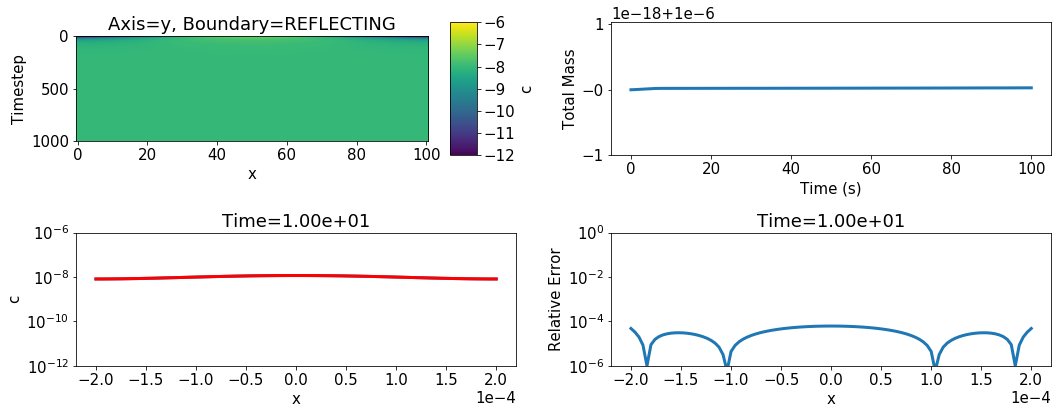

[one_d_diffusion_reflecting_z]                               : passed.


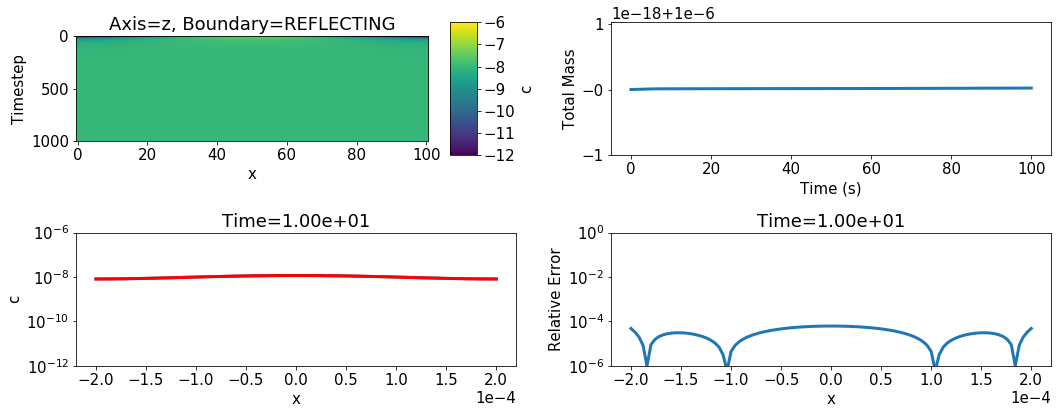

[one_d_diffusion_absorbing_x]                                : passed.


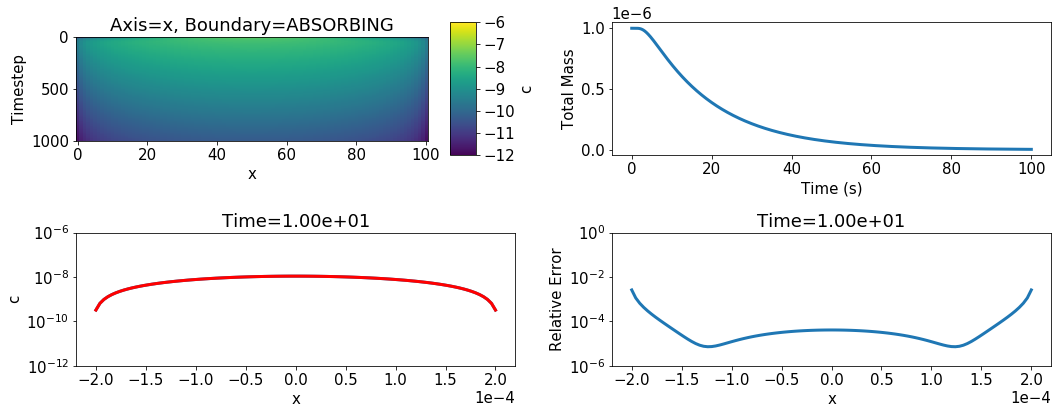

[one_d_diffusion_absorbing_y]                                : passed.


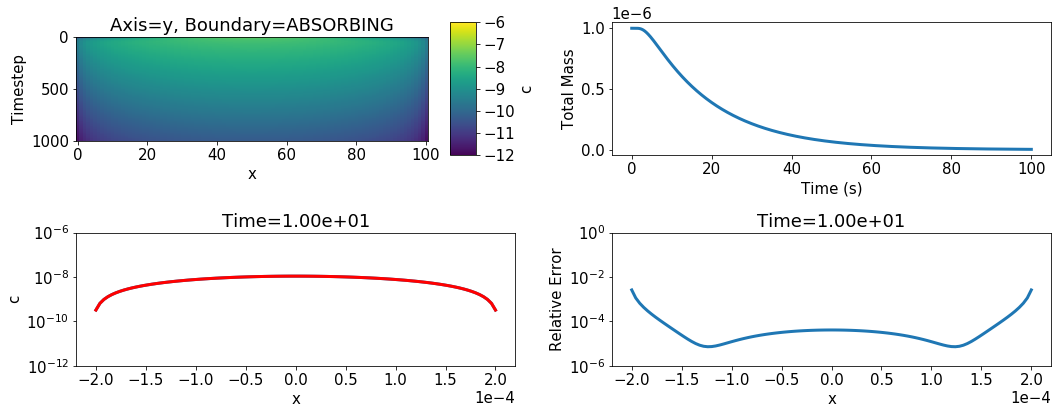

[one_d_diffusion_absorbing_z]                                : passed.


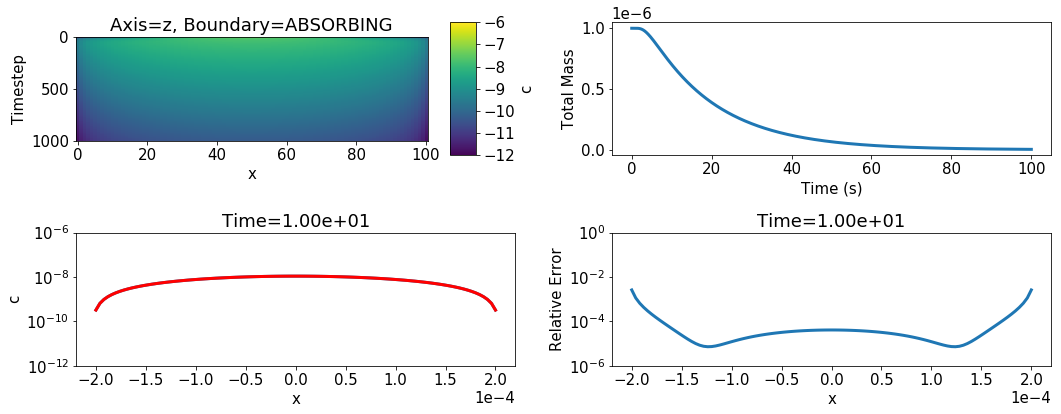

[one_d_diffusion_linear_x]                                   : passed.


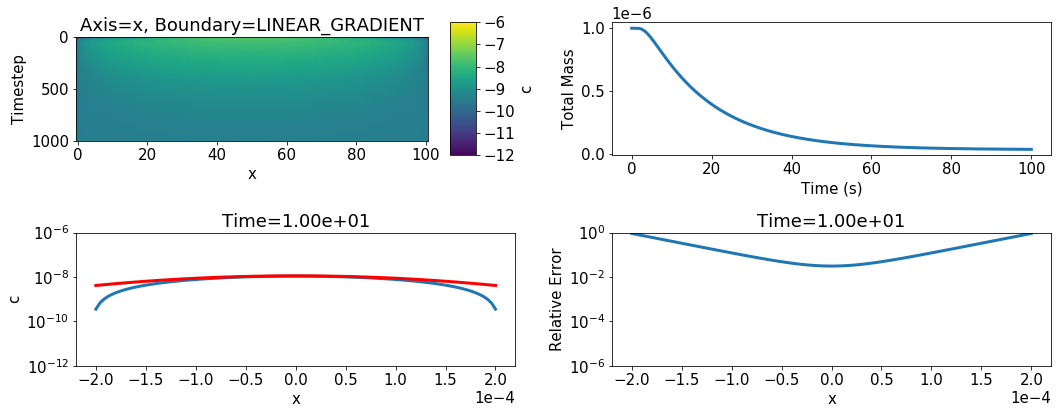

[one_d_diffusion_linear_y]                                   : passed.


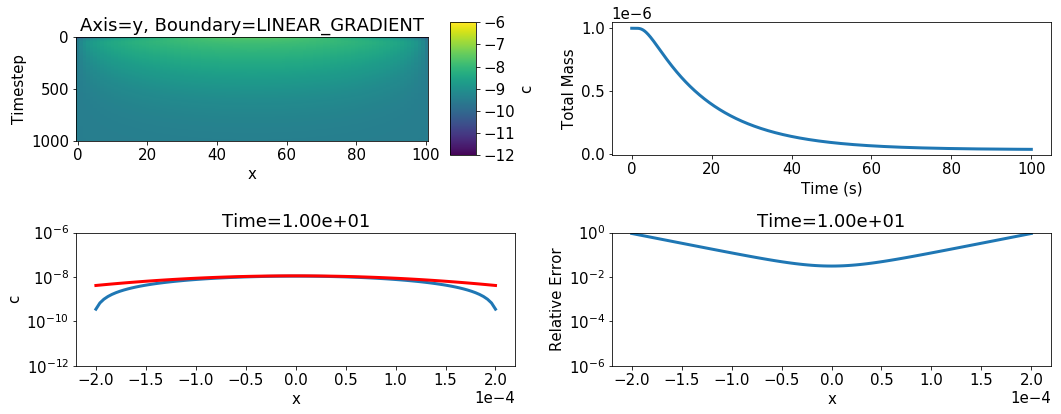

[one_d_diffusion_linear_z]                                   : passed.


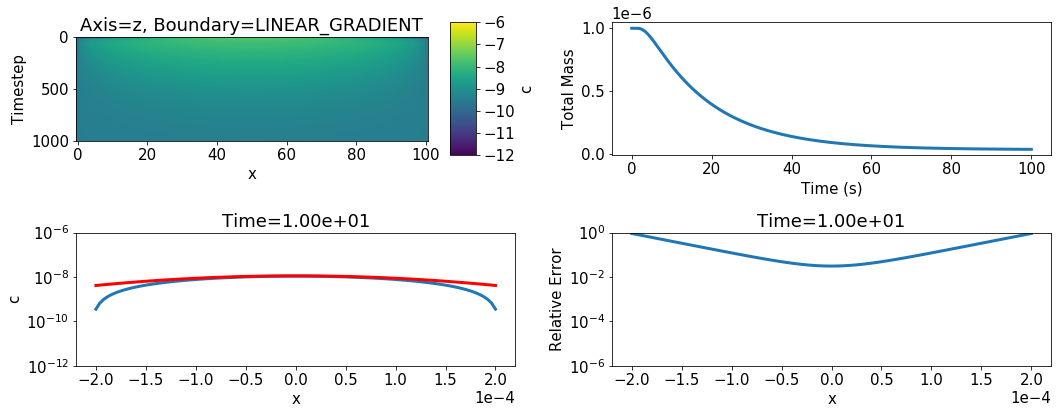

[one_d_diffusion_large_linear]                               : passed.


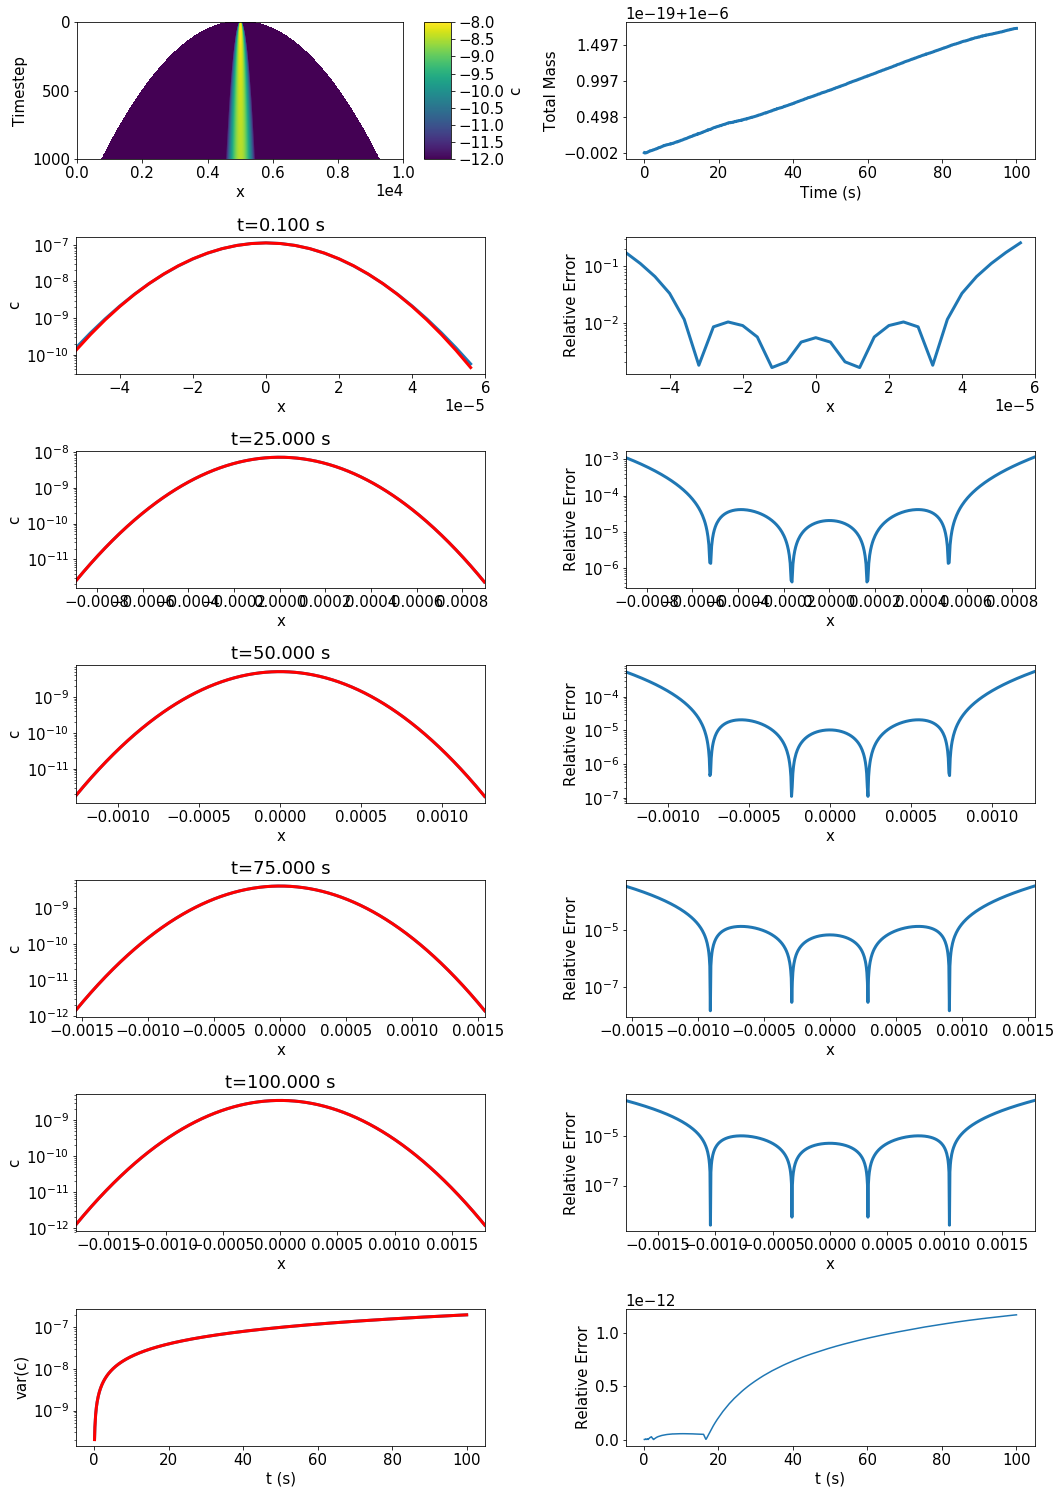

[two_d_diffusion]                                            : passed.


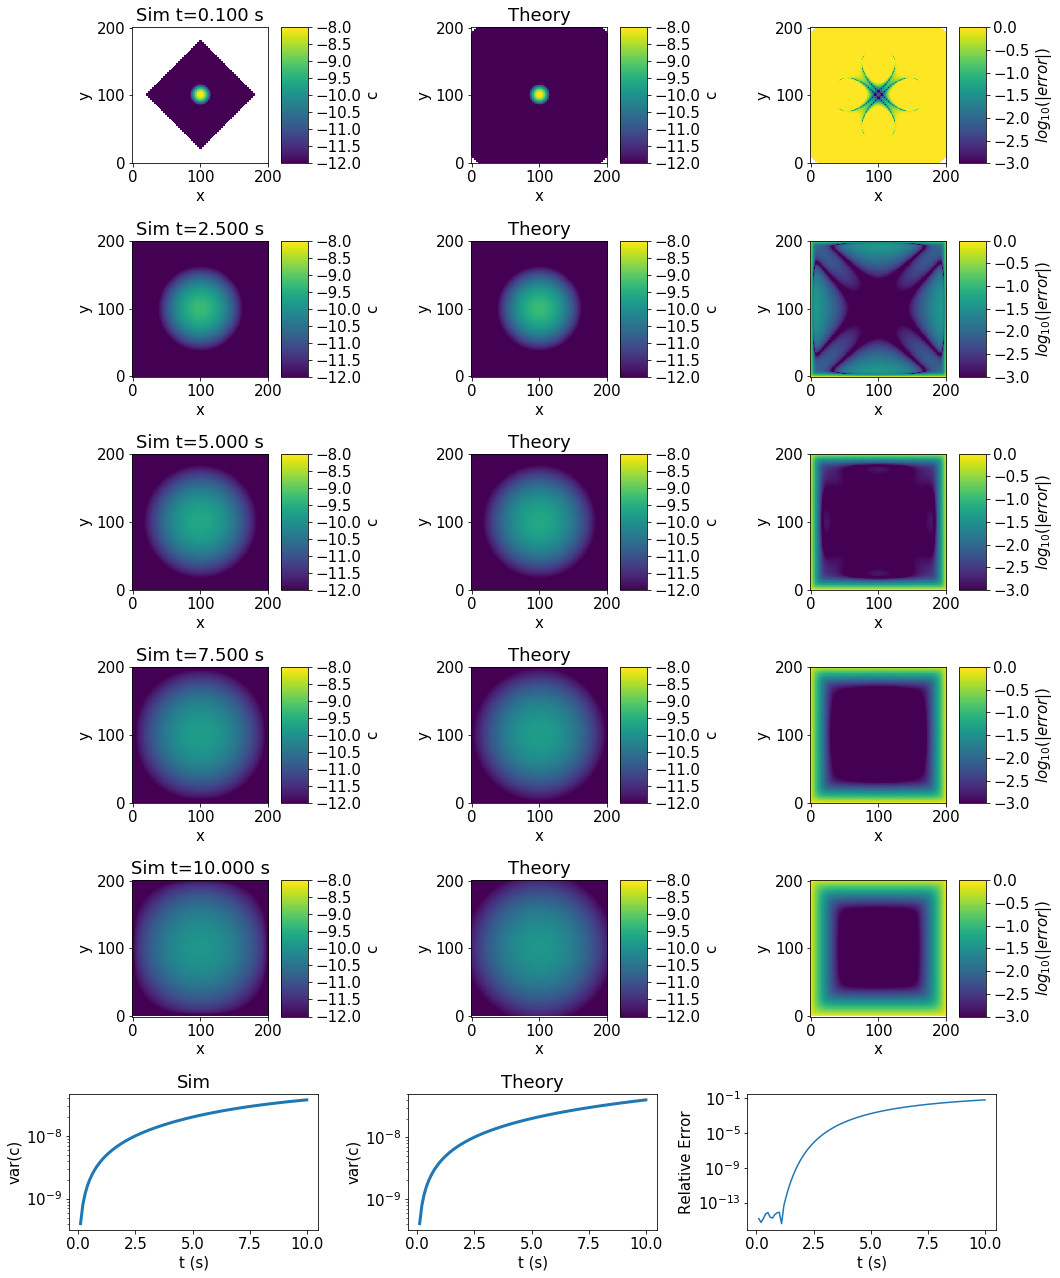

[three_d_diffusion]                                          : passed.


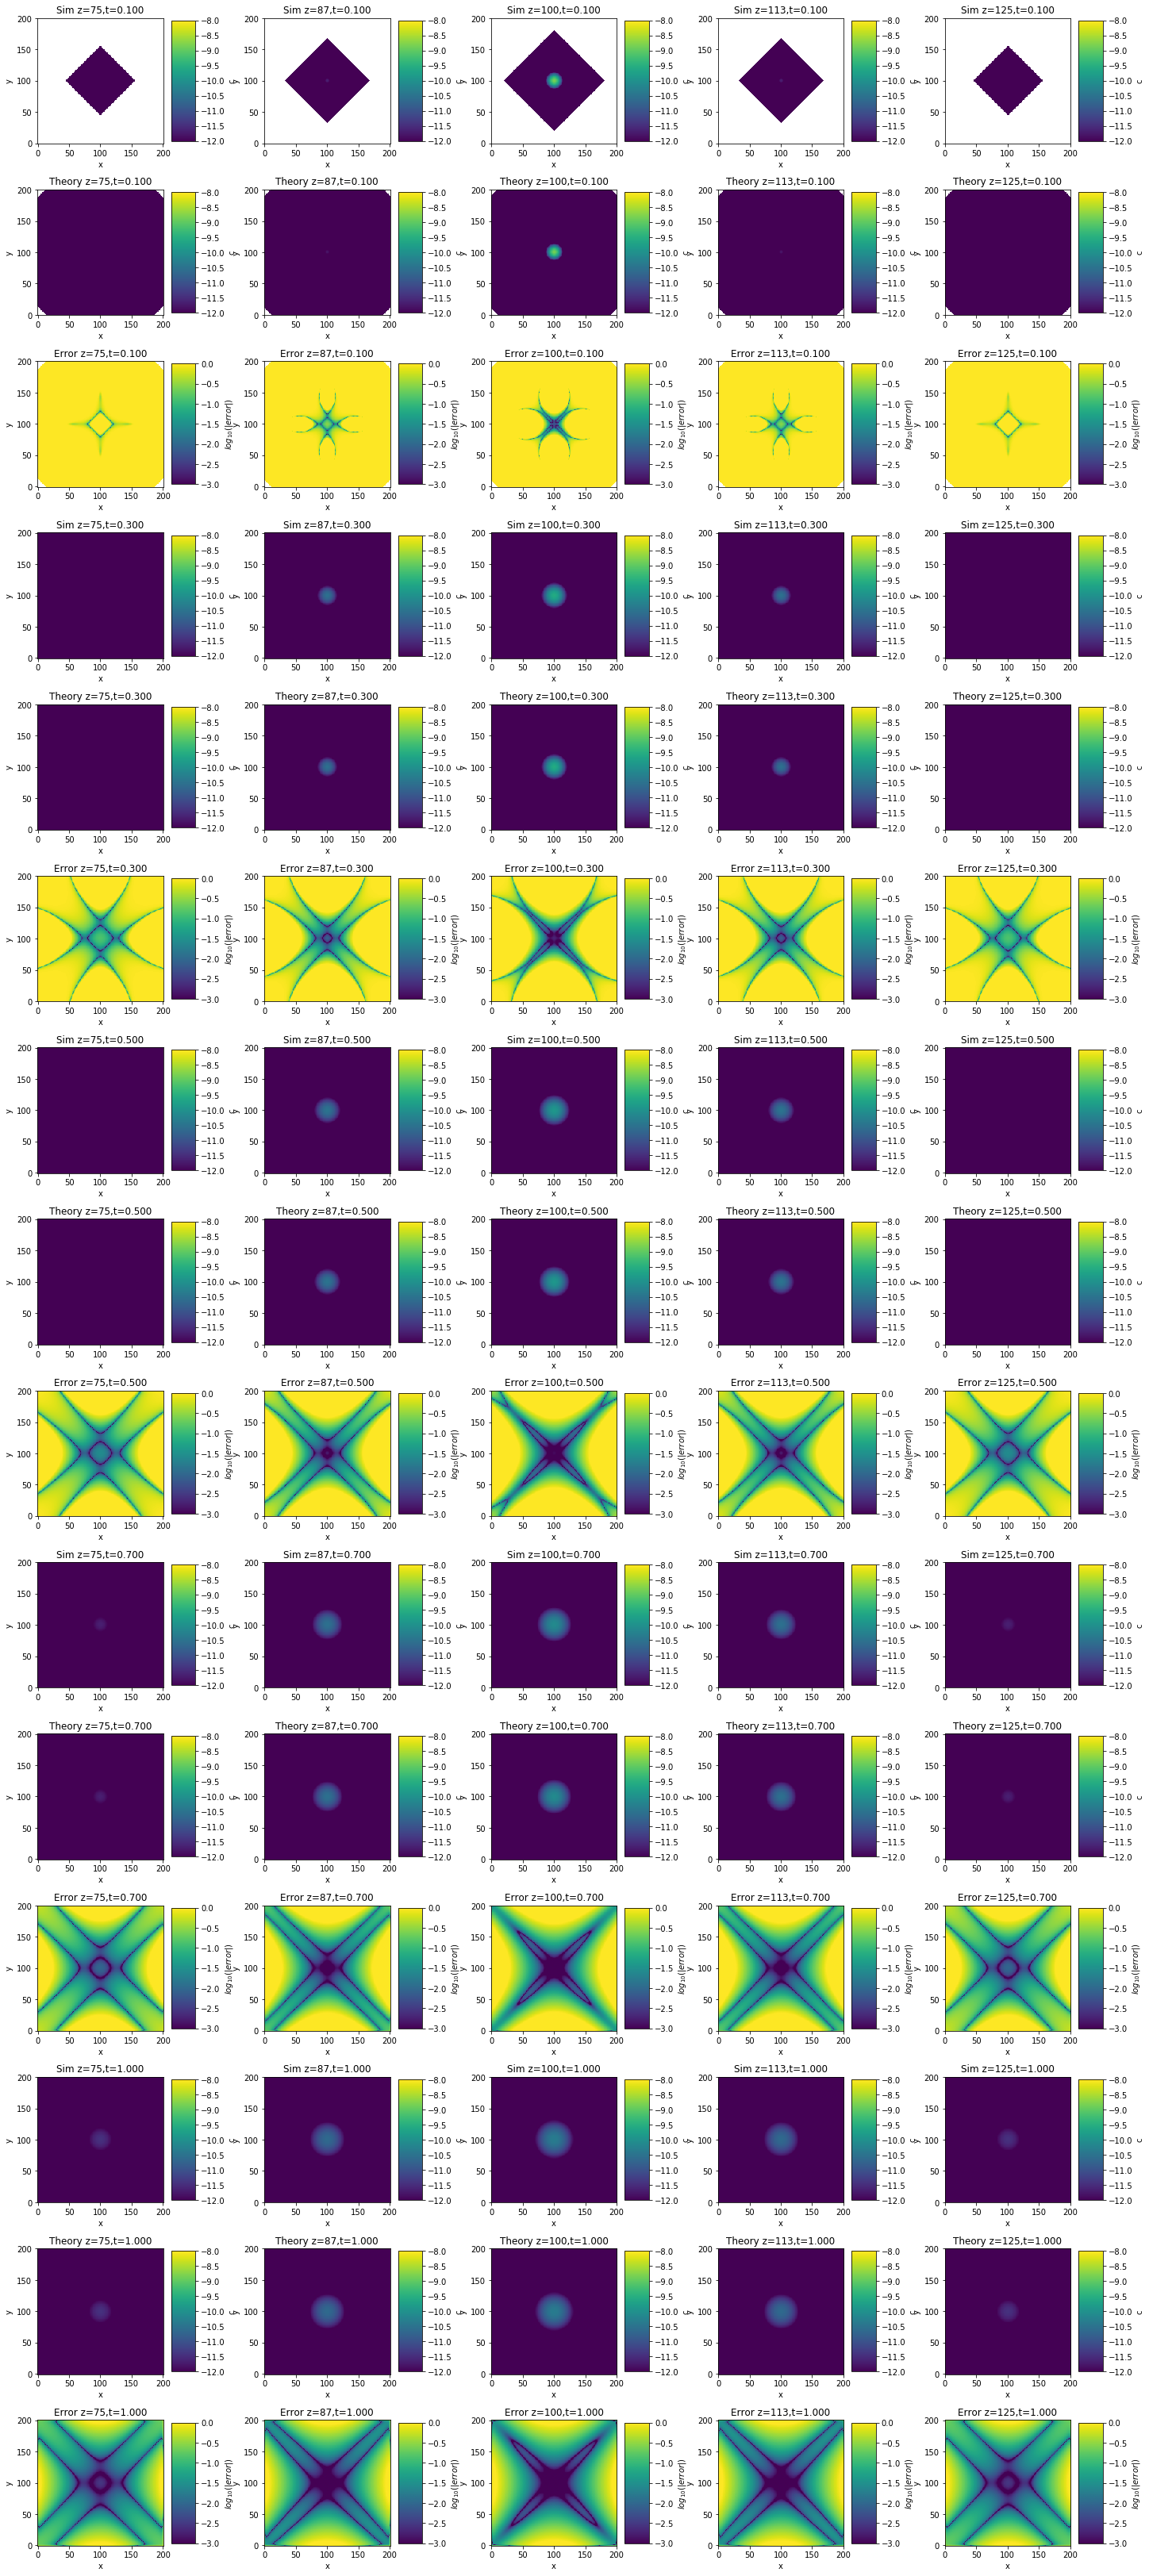

In [91]:
testMethods = {"one_d_diffusion_reflecting_x": test_one_d_diffusion,
               "one_d_diffusion_reflecting_y": test_one_d_diffusion,
               "one_d_diffusion_reflecting_z": test_one_d_diffusion,
               "one_d_diffusion_absorbing_x": test_one_d_diffusion,
               "one_d_diffusion_absorbing_y": test_one_d_diffusion,
               "one_d_diffusion_absorbing_z": test_one_d_diffusion,
               "one_d_diffusion_linear_x": test_one_d_diffusion,
               "one_d_diffusion_linear_y": test_one_d_diffusion,
               "one_d_diffusion_linear_z": test_one_d_diffusion,
               "one_d_diffusion_large_linear": test_one_d_diffusion_large_linear,
               "two_d_diffusion": test_two_d_diffusion,
               "three_d_diffusion": test_three_d_diffusion}
for testName in testNames:
    try:
        testOutputFilename="tmp/%s.sfile"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.tight_layout()
    plt.show()
pass

In [92]:
%%bash
rm -rf tmp